In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import cv2
import os
import glob
from tqdm import tqdm
import numpy as np
np.random.seed = 42
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras.utils import plot_model
from tf_explain.core.grad_cam import GradCAM
from sklearn.model_selection import train_test_split
import pandas as pd

In [5]:
root_dir = '/content/drive/MyDrive/input/Dataset_BUSI_with_GT'
os.listdir(root_dir)

['.DS_Store', 'malignant', 'normal', 'benign']

In [6]:
IMG_WIDTH = 224
IMG_HIGH = 224  #image is 224*224
IMG_CHANNELS = 3 # number of input channels


In [7]:
def LoadData(root_dir, FolderName, img_width=IMG_WIDTH, img_high=IMG_HIGH, img_channels=IMG_CHANNELS):
  num_samples = 0
  for address in glob.glob(root_dir + f'/{FolderName}/*'):
    s_address = address.split()[-1] #從最後一個image開始抓image_name
    s_address = s_address.split('.')[0] #去除image_name裡的"."
    s_address = s_address.split('_') #去除image_name裡的"_"
    if len(s_address) == 1:
      num_samples += 1

  X = np.zeros((num_samples, img_high, img_width, img_channels), dtype=np.uint8)
  Y = np.zeros((num_samples, img_high, img_width, 1), dtype=np.bool8)


  for address in tqdm(glob.glob(root_dir + f'/{FolderName}/*')): #讀輸出條
    img = cv2.imread(address)#讀圖片
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(img, (img_width, img_high), interpolation=cv2.INTER_CUBIC)

    s_address = address.split()[-1]
    s_address = s_address.split('.')[0]
    s_address = s_address.split('_')

    idx = s_address[0]
    idx = int(idx.split('(')[1].split(')')[0]) - 1

    if len(s_address) == 1:
      X[idx] = resized_image
      
    elif len(s_address) > 1:
      mask = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
      
      mask = np.expand_dims(mask, axis=-1)
      Y[idx] = np.maximum(mask, Y[idx])

  return X, Y

In [8]:
#load image data of benign/malignant/normal
#這時我的x是超音波照，y是mask
x_benign, y_benign = LoadData(root_dir, 'benign')
x_malignant, y_malignant = LoadData(root_dir, 'malignant')
x_normal, y_normal = LoadData(root_dir, 'normal')

100%|██████████| 266/266 [00:05<00:00, 47.16it/s]


In [23]:
len(x_benign), len(x_malignant), len(x_normal)
#benign/malignant/normal的數量(437, 215, 133)

(437, 215, 133)

In [40]:
x_benign.shape,x_malignant.shape,x_normal.shape
#看一下benign/malignant/normal的圖片大小跟顏色通道
#((437, 224, 224, 3), (215, 224, 224, 3), (133, 224, 224, 3))

((437, 224, 224, 3), (215, 224, 224, 3), (133, 224, 224, 3))

In [41]:
#建立label 用dataforme
#benign/malignant/normal各有437/215/133張圖，所以要建立相對數量的label
#0為benign/1為malignant/2為normal
benign = []
for i in range(1,438):
    benign.append(0)
benign = pd.DataFrame(benign)

malignant = []
for i in range(1,216):
    malignant.append(1)
malignant = pd.DataFrame(malignant)

normal = []
for i in range(1,134):
    normal.append(2)
normal = pd.DataFrame(normal)


In [42]:
#concat the image and label
X = np.concatenate((x_benign, x_malignant, x_normal), axis=0)
y = np.concatenate((benign, malignant, normal), axis=0)
print(X.shape, y.shape)
#(785, 224, 224, 3) (785, 1)

(785, 224, 224, 3) (785, 1)


In [43]:
#split to train, test. 70% train 30%test, have stratify=y.(balance the data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3,  stratify=y, random_state=11)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#(549, 224, 224, 3) (236, 224, 224, 3) (549, 1) (236, 1)

(549, 224, 224, 3) (236, 224, 224, 3) (549, 1) (236, 1)


In [44]:
#OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
y_train = onehotencoder.fit_transform(y_train).toarray()
#y_test = onehotencoder.fit_transform(y_test).toarray()
print(y_train.shape, y_test.shape)
#(549, 3) (236, 3)

(549, 3) (236, 1)


In [45]:
#split train again into validation and train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train ,test_size=0.2,
                            stratify=y_train, random_state=11)
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)
#(439, 224, 224, 3) (236, 224, 224, 3) (110, 224, 224, 3) (439, 3) (236, 3) (110, 3)

(439, 224, 224, 3) (236, 224, 224, 3) (110, 224, 224, 3) (439, 3) (236, 1) (110, 3)


In [46]:
#Data_Augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        #rescale=1./255,         # 特徵縮放 (後來在做)
        rotation_range=10,      # 旋轉 10 度
        zoom_range=0.05,         # 拉遠/拉近 5%
        width_shift_range=0.05,  # 寬度偏移  5%
        height_shift_range=0.05) # 高度偏移  5%

In [47]:
# 特徵縮放
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

In [48]:
# 增補資料，進行模型訓練
datagen.fit(X_train)
datagen.fit(X_val)

In [49]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D

import tensorflow as tf
from keras.models import Model
from keras import layers
from keras import backend as K

from tensorflow.keras.optimizers import Adam


In [50]:
###VGG11
img_input = layers.Input(shape = (224, 224, 3))
#Black1
x = layers.Conv2D(64, 3, activation = 'relu')(img_input)
x = layers.MaxPooling2D(2,2)(x)
#Black2
x = layers.Conv2D(128, 3, activation = 'relu')(x)
x = layers.MaxPooling2D(2,2)(x)
#Black3
x = layers.Conv2D(256, 3, activation = 'relu')(x)
x = layers.Conv2D(256, 3, activation = 'relu')(x)
x = layers.MaxPooling2D(2,2)(x)
#Black4
x = layers.Conv2D(512, 3, activation = 'relu')(x)
x = layers.Conv2D(512, 3, activation = 'relu')(x)
x = layers.MaxPooling2D(2,2)(x)
#Black5
x = layers.Conv2D(512, 3, activation = 'relu')(x)
x = layers.Conv2D(512, 3, activation = 'relu')(x)
x = layers.MaxPooling2D(2,2)(x)

x = layers.Flatten()(x)

x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dense(1024, activation = 'relu')(x)

output = layers.Dense(3, activation = 'sigmoid')(x)

model = Model(img_input, output)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 256)       2951

In [51]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003),
    loss = 'categorical_crossentropy',  #tf.keras.losses.CategoricalCrossentropy() tf.keras.losses.SparseCategoricalCrossentropy()
    metrics = ["accuracy"])

In [52]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=64), epochs=100, 
                    validation_data=datagen.flow(X_val, y_val, batch_size=64))
#epochs=100訓練100次 datagen.flow要套用Data_Augmentation的效果

Epoch 1/100
7/7 [==============================] - 12s 1s/step - loss: 1.0084 - accuracy: 0.4989 - val_loss: 1.0505 - val_accuracy: 0.5545
Epoch 2/100
7/7 [==============================] - 6s 902ms/step - loss: 1.0214 - accuracy: 0.5581 - val_loss: 0.9679 - val_accuracy: 0.5545
Epoch 3/100
7/7 [==============================] - 7s 1s/step - loss: 0.9539 - accuracy: 0.5581 - val_loss: 0.9693 - val_accuracy: 0.5545
Epoch 4/100
7/7 [==============================] - 6s 869ms/step - loss: 0.9544 - accuracy: 0.5581 - val_loss: 0.9198 - val_accuracy: 0.5545
Epoch 5/100
7/7 [==============================] - 7s 1s/step - loss: 0.9765 - accuracy: 0.5877 - val_loss: 0.9554 - val_accuracy: 0.5636
Epoch 6/100
7/7 [==============================] - 6s 888ms/step - loss: 0.9445 - accuracy: 0.5695 - val_loss: 0.9369 - val_accuracy: 0.6182
Epoch 7/100
7/7 [==============================] - 7s 1s/step - loss: 0.9158 - accuracy: 0.6219 - val_loss: 0.8722 - val_accuracy: 0.6364
Epoch 8/100
7/7 [=======

In [53]:
#predict the y
pred_y = model.predict(X_test)
pred = np.argmax(pred_y, axis=1)
print(pred)

8/8 [==============================] - 1s 59ms/step
[1 1 1 0 1 1 1 0 0 0 0 0 2 0 0 0 0 2 0 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 0 0
 0 0 0 1 0 1 0 1 0 0 1 1 2 2 2 1 1 0 0 2 2 2 0 0 0 0 0 1 1 0 1 0 1 2 0 0 0
 0 0 0 0 0 2 2 0 2 1 1 0 1 0 0 0 2 0 0 0 0 2 0 0 1 0 0 0 0 1 0 0 1 2 0 2 2
 0 1 0 0 0 0 0 1 0 0 0 0 1 1 2 0 2 0 1 0 0 0 0 0 1 1 2 1 0 0 1 1 1 1 0 0 0
 0 2 0 2 0 0 0 0 0 0 0 1 1 0 1 0 1 0 2 0 0 0 0 1 0 0 0 0 0 2 1 0 0 0 0 1 0
 1 2 0 0 0 0 0 2 1 1 0 2 0 0 0 0 1 1 0 1 0 2 2 0 1 0 1 0 0 0 0 1 1 0 1 0 0
 1 0 1 0 1 0 0 0 1 2 0 0 1 1]


In [54]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.7203389830508474

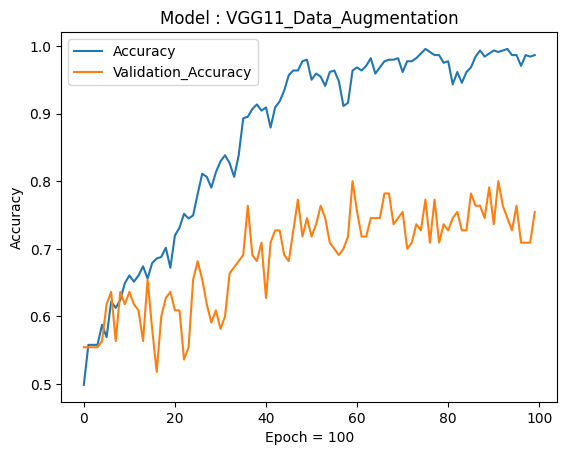

In [55]:
import matplotlib.pyplot as plt
#plot model accuracy_plot
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("Accuracy")
plt.xlabel("Epoch = 100")
plt.legend(["Accuracy","Validation_Accuracy"])
plt.title("Model : VGG11_Data_Augmentation")
plt.show()

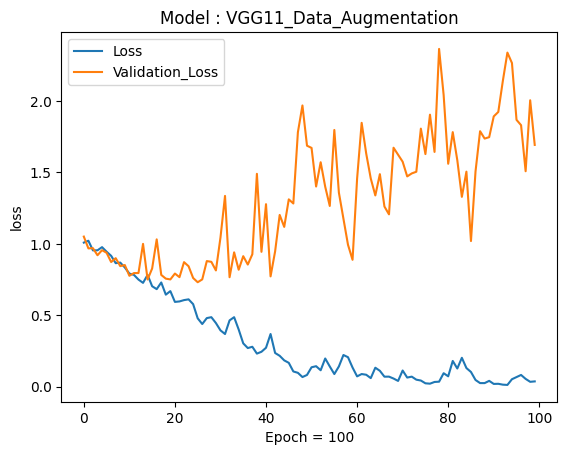

In [56]:
#plot model loss_plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss")
plt.xlabel("Epoch = 100")
plt.legend(["Loss","Validation_Loss"])
plt.title("Model : VGG11_Data_Augmentation")
plt.show()
